# **Global Population Assessment**
<span style = "font-size: 1.5em;"> ***WorldPop Global Project Population Data: Estimated Residential Population per 100x100m Grid Square 2000-2020*** </span>

## Brief Description

### <span style = "font-size: 1em;"> ***Brief Description of The Asssessment*** </span>

The assessment will estimate the spatial information of population count in the region of interest and 3km and 10 km buffer along with the jurisdictional. Historical population change will be estimated by summation of the population count within the region

<span style="font-size:1.1em;"> ***Input Data Needed*** </span>
- Shapefile
> - **roi_directory** : specify region of interest shapefiile
> - **jurisdictional_directory** : select jurisdictional shapefile

- Input Data Variables
> - **projectname (string)** : project name (example: "RVL_IDN_KubuRaya")
> - **jurisdictional name (string)** : jurisdictional name (example: "Kubu Raya")
> - **projection**: UTM projection code in code (example: "EPSG:3857")
> - **roi_column_name** : variable name that specifiy unique ID for multipolygon analysis (example: "Name")

- Output directory folder
> - **output_directory** : select directory folder to put the output result

<span style="font-size:1.1em;"> ***Expected Output*** </span>
- Raster Datasets
> WorldPop Population Count rasters datasets in 2000, 2005, 2010, 2015, 2020 in in Jurisdictional Area

- csv files
> Historical Population Change in RoI, Jurisdictional and Buffer 3km and 10km

### <span style = "font-size: 1em;"> ***Brief Description of The Dataset*** </span>

Recent census-based population counts matched to their associated administrative units are disaggregated to ~100x100m grid cells through machine learning approaches that exploit the relationships between population densities and a range of geospatial covariate layers. The mapping approach is Random Forest-based dasymetric redistribution. This dataset depict estimated number of people residing in each grid cell in 2010, 2015, and other years.

The value represent estimated number of people residing in each grid cell (Resolution = 100 meter)

<span style="font-size:1.1em;"> ***Source*** </span>

- Americas population data: Alessandro Sorichetta, Graeme M. Hornby, Forrest R. Stevens, Andrea E. Gaughan, Catherine Linard, Andrew J. Tatem, 2015, High-resolution gridded population datasets for Latin America and the Caribbean in 2010, 2015, and 2020, Scientific Data, [doi:10.1038/sdata.2015.45](https://www.nature.com/articles/sdata201545)
- Africa population count data: Linard, C., Gilbert, M., Snow, R.W., Noor, A.M. and Tatem, A.J., 2012, Population distribution, settlement patterns and accessibility across Africa in 2010, PLoS ONE, 7(2): e31743. [doi:10.1371/journal.pone.0031743](https://doi.org/10.1371/journal.pone.0031743)
- Asia population count data: Gaughan AE, Stevens FR, Linard C, Jia P and Tatem AJ, 2013, High resolution population distribution maps for Southeast Asia in 2010 and 2015, PLoS ONE, 8(2): e55882 [doi:10.1371/journal.pone.0055882](https://doi.org/10.1371/journal.pone.0055882)

## Data Preparation

In [56]:
%matplotlib inline
import os
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from geemap import cartoee
import cartopy.io.img_tiles as cimgt

In [57]:
import ee
import geemap
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [58]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
jurisdictional_directory = filedialog.askopenfile(title = 'Open Jurisdictional Shapefile')
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [59]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
# specify project name
jurisdictionalname = simpledialog.askstring("Input", "Speficy Jurisdictional name",parent=root)

if jurisdictionalname is not None:
    print("The script will assess ", jurisdictionalname)
else:
    print("Jurisdictional Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection)
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Ruvuma CAA
The script will assess  Ruvuma District
All data will be reprojected to  EPSG:32737
Column name is  ID


In [60]:
# output directory
out_dir = os.path.expanduser(output_directory+'/RapidScreening_PopulationAssessment')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Data reprojection and buffer creation

In [61]:
roi = gpd.read_file(roi_directory.name)
roi_proj  = roi.to_crs(crs = projection)

jurisdictional = gpd.read_file(jurisdictional_directory.name)
jurisdictional_proj = jurisdictional.to_crs(crs = projection)

In [62]:
#  Create Buffer
buf3km = roi_proj.copy()
buf10km = roi_proj.copy()

# Create RoI + Buffer 3km
buf3km['geometry'] = buf3km.geometry.buffer(distance = 3000)
# Create RoI + Buffer 10km
buf10km['geometry'] = buf10km.geometry.buffer(distance = 10000)

# create ring buffer through symmetrical difference
# overlapped ring buffer
ring_buf3km = buf3km.copy()
ring_buf3km['geometry'] = buf3km.symmetric_difference(roi_proj)
#ring_buf3km = buf3km.overlay(roi_import_proj, how ='symmetric_difference', keep_geom_type=False)
# outer ring buffer
#ring_buf3km = buf3km.overlay(roi_import_proj, how ='difference', keep_geom_type=False)

# overlapped ring buffer
ring_buf10km = buf10km.copy()
ring_buf10km['geometry'] = ring_buf10km.symmetric_difference(roi_proj)
#ring_buf10km = buf10km.overlay(roi_import_proj, how ='symmetric_difference', keep_geom_type=False)
# outer ring buffer
#ring_buf10km = buf10km.overlay(roi_import_proj, how ='difference', keep_geom_type=False)

#buf3km.plot()
#buf10km.plot()
#roi_import_proj.plot()
#ring_buf3km.plot()
#ring_buf10km.plot()

In [63]:
# 1 Reprojection for population estimation
roi_proj_gee = geemap.geopandas_to_ee(roi_proj, geodesic=False)
jurisdictional_proj_gee = geemap.geopandas_to_ee(jurisdictional_proj, geodesic = False)

# convert to feature collection
roi_buffer_3km_gee = geemap.geopandas_to_ee(ring_buf3km, geodesic=False)
roi_buffer_10km_gee = geemap.geopandas_to_ee(ring_buf10km, geodesic=False)

In [64]:
# 2 Reprojection for Map Visualization
roi_proj_4326 = roi.to_crs(crs = "EPSG:4326")
roi_proj_4326_gee = geemap.geopandas_to_ee(roi_proj_4326, geodesic=False)

jurisdictional_proj_4326 = jurisdictional_proj.to_crs(crs = 'EPSG:4326')
jurisdictional_proj_4326_gee = geemap.geopandas_to_ee(jurisdictional_proj_4326, geodesic=False)

roi_buffer_3km_4326 = ring_buf3km.to_crs(crs = 'EPSG:4326')
roi_buffer_3km_4326_gee = geemap.geopandas_to_ee(roi_buffer_3km_4326, geodesic=False)
roi_buffer_10km_4326 = ring_buf10km.to_crs(crs = 'EPSG:4326')
roi_buffer_10km_4326_gee = geemap.geopandas_to_ee(roi_buffer_10km_4326, geodesic=False)
                                                      
# Boundaries extent        
bounds_roi = jurisdictional_proj_4326.total_bounds
bbox_roi = [bounds_roi[2], bounds_roi[1], bounds_roi[0], bounds_roi[3]]

### Visualization Parameters

In [65]:
# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}
# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 20,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}

In [66]:
vis_roi = {'color': '#FF0000', 'width': 1,'lineType': 'solid','fillColor': '00000000'}
vis_jur = {'color': 'white', 'width': 2, 'lineType': 'solid', 'fillColor': '00000000'}
vis_buf10km = {'color': 'blue', 'width': 2, 'lineType': 'solid', 'fillColor': '00000000'}
worldpopCount_visParameter = {'palette': ['060606', '337663', 'f5b301', 'fed053'], 'min' : 0, 'max': 20};
colors_worldpopCount_PopCount = ['060606', '337663', 'f5b301', 'fed053']
cmap_worldpopCount = ListedColormap(colors_worldpopCount_PopCount)

## Population Count Estimation

### Geospatial Population Distribution

#### Population Count in 2020

In [67]:
years_WorldPop = ee.List.sequence(2000, 2020, 5)

def get_WorldPop_images(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection('WorldPop/GP/100m/pop')
        .filterDate(start_date, end_date)
        .select('population')
    )
    return ee.Image(image)

collection_WorldPop = ee.ImageCollection(years_WorldPop.map(get_WorldPop_images))

In [68]:
worldpop_roi_2020 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2020-01-01','2020-12-31').median().clip(roi_proj_4326_gee)
worldpop_jurisdictional_2020 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2020-01-01','2020-12-31').median().clip(jurisdictional_proj_4326_gee)
worldpop_RingBuffer3km_2020 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2020-01-01','2020-12-31').median().clip(roi_buffer_3km_4326_gee)
worldpop_RingBuffer10km_2020 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2020-01-01','2020-12-31').median().clip(roi_buffer_10km_4326_gee)

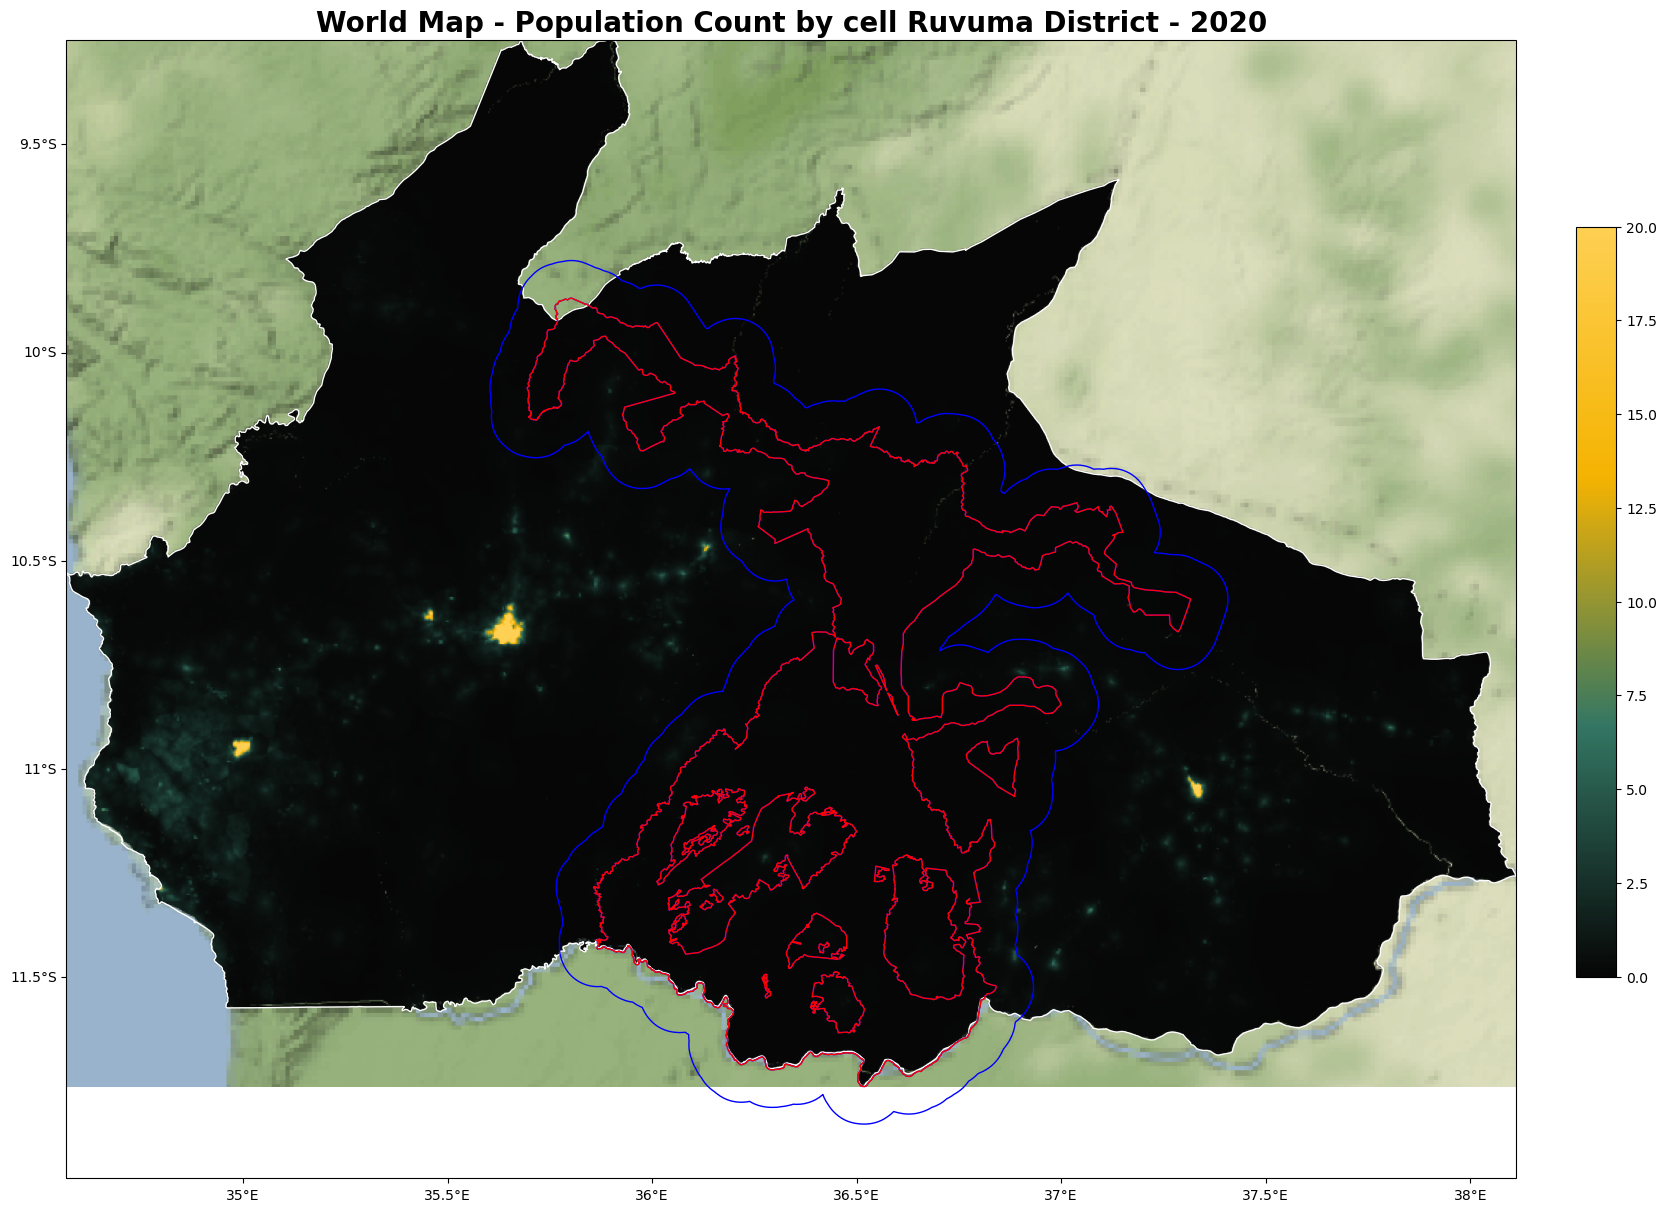

In [69]:
#roi_proj_4326['coords'] = roi_proj_4326['geometry'].apply(lambda x: x.representative_point().coords[:])

fig_WorldPop = plt.figure(figsize=(20, 15),  facecolor = 'white', frameon=True)

# plot the result with cartoee using a PlateCarre projection (default)
ax_WorldPop = cartoee.get_map(
    worldpop_jurisdictional_2020,
    vis_params=worldpopCount_visParameter,
    region=bbox_roi,
    basemap=cimgt.Stamen('terrain-background'),
    zoom_level=7,
)
ax_WorldPop = jurisdictional_proj_4326.plot(color = None, edgecolor = 'white', facecolor="none", ax = ax_WorldPop)
ax_WorldPop = roi_buffer_10km_4326.plot(color = None, edgecolor = 'blue', facecolor = 'none', ax = ax_WorldPop)
ax_WorldPop = roi_proj_4326.plot(color = None, edgecolor = 'red', facecolor = 'none', ax = ax_WorldPop)
cb_WorldPop = cartoee.add_colorbar(ax_WorldPop, vis_params=worldpopCount_visParameter, loc='right', cmap = cmap_worldpopCount )

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax_WorldPop, interval=[0.5, 0.5],alpha=0, linestyle=":")
cartoee.add_scale_bar_lite(ax_WorldPop, **scale_bar_dict)
ax_WorldPop.set_title(label='World Map - Population Count by cell '+  jurisdictionalname + " - 2020", fontsize=20, fontweight="bold")

#ax_WorldPop.coastlines()

#for idx, row in roi_proj_4326.iterrows():
#    plt.annotate(text=row[roi_column_name], xy=row['coords'])#, horizontalalignment='center', color='blue')

# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig(os.path.join(out_dir, projectname + '_WorldPop_PopCount2020_Map.png'), bbox_inches='tight', facecolor=fig_WorldPop.get_facecolor())
plt.show()

#### Historical Population 2000-2020

In [70]:
# 1. WorldPop 2000
WorldPop_dataset_2000 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2000-01-01', '2000-12-31').median()
WorldPop_dataset_2000_proj = WorldPop_dataset_2000.reproject(crs = projection, scale = 100)
WorldPop_PopCount_2000_proj = WorldPop_dataset_2000_proj.select('population')

# 2. WorldPop 2005
WorldPop_dataset_2005 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2005-01-01', '2005-12-31').median()
WorldPop_dataset_2005_proj = WorldPop_dataset_2005.reproject(crs = projection, scale = 100)
WorldPop_PopCount_2005_proj = WorldPop_dataset_2005_proj.select('population')

# 3. WorldPop 2010
WorldPop_dataset_2010 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2010-01-01', '2010-12-31').median()
WorldPop_dataset_2010_proj = WorldPop_dataset_2010.reproject(crs = projection, scale = 100)
WorldPop_PopCount_2010_proj = WorldPop_dataset_2010_proj.select('population')

# 4. WorldPop 2015
WorldPop_dataset_2015 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2015-01-01', '2015-12-31').median()
WorldPop_dataset_2015_proj = WorldPop_dataset_2015.reproject(crs = projection, scale = 100)
WorldPop_PopCount_2015_proj = WorldPop_dataset_2015_proj.select('population')

# 5. WorldPop 2020
WorldPop_dataset_2020 = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate('2020-01-01', '2020-12-31').median()
WorldPop_dataset_2020_proj = WorldPop_dataset_2020.reproject(crs = projection, scale = 100)
WorldPop_PopCount_2020_proj = WorldPop_dataset_2020_proj.select('population')

In [72]:
# clip by jurisdictional
WorldPop_PopCount_2000_proj_jur = WorldPop_PopCount_2000_proj.clip(jurisdictional_proj_gee)
WorldPop_PopCount_2005_proj_jur = WorldPop_PopCount_2005_proj.clip(jurisdictional_proj_gee)
WorldPop_PopCount_2010_proj_jur = WorldPop_PopCount_2010_proj.clip(jurisdictional_proj_gee)
WorldPop_PopCount_2015_proj_jur = WorldPop_PopCount_2015_proj.clip(jurisdictional_proj_gee)
WorldPop_PopCount_2020_proj_jur = WorldPop_PopCount_2020_proj.clip(jurisdictional_proj_gee)

In [73]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

Map.centerObject(jurisdictional_proj_gee, 8)

# Add individual layer map
Map.addLayer(WorldPop_PopCount_2000_proj_jur, worldpopCount_visParameter, '2000 - WorldPop Population Count', False)
Map.addLayer(WorldPop_PopCount_2005_proj_jur, worldpopCount_visParameter, '2005 - WorldPop Population Count', False)
Map.addLayer(WorldPop_PopCount_2010_proj_jur, worldpopCount_visParameter, '2010 - WorldPop Population Count', False)
Map.addLayer(WorldPop_PopCount_2015_proj_jur, worldpopCount_visParameter, '2015 - WorldPop Population Count', False)
Map.addLayer(WorldPop_PopCount_2020_proj_jur, worldpopCount_visParameter, '2020 - WorldPop Population Count')
Map.addLayer(jurisdictional_proj_gee.style(**vis_jur), {}, "Jurisdictional")
Map.addLayer(roi_buffer_10km_gee.style(**vis_buf10km), {}, "Buffer10Km")
Map.addLayer(roi_proj_gee.style(**vis_roi), {}, "Region of Interest")

Map

Map(center=[-10.72450056600774, 36.250572974038796], controls=(WidgetControl(options=['position', 'transparent…

In [18]:
SplitMap = geemap.Map()
SplitMap.add_basemap('HYBRID')

SplitMap.centerObject(roi_proj_gee, 8)

left_layer = geemap.ee_tile_layer(WorldPop_PopCount_2000_proj_jur, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2000')
right_layer = geemap.ee_tile_layer(WorldPop_PopCount_2020_proj_jur, worldpopCount_visParameter, 'RoI - WorldPop Population Count 2020')
SplitMap.split_map(left_layer, right_layer)
SplitMap

Map(center=[-16.881003784443724, -43.96077914746865], controls=(ZoomControl(options=['position', 'zoom_in_text…

#### Export Raster Data

In [74]:
ring_buf3km.to_file(os.path.join(out_dir, projectname + '_RingBuffer3km.shp'))
ring_buf10km.to_file(os.path.join(out_dir, projectname + '_RingBuffer10km.shp'))

In [75]:
# World Population at Jurisdictional level

# 1. WorldPop Population Density 2000
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2000_proj_jur,
    description = projectname + '_WorldPop_PopCount_2000_jur',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2000_jur',
    scale = 100,
    crs = projection,
    maxPixels= 1e12,
    region = jurisdictional_proj_gee.geometry()
)

# 2. WorldPop Population Density 2005
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2005_proj_jur,
    description = projectname + '_WorldPop_PopCount_2005_jur',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2005_jur',
    scale = 100,
    crs = projection,
    maxPixels= 1e12,
    region = jurisdictional_proj_gee.geometry()
)

# 3. WorldPop Population Density 2010
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2010_proj_jur,
    description = projectname + '_WorldPop_PopCount_2010_jur',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2010_jur',
    scale = 100,
    crs = projection,
    maxPixels= 1e12,
    region = jurisdictional_proj_gee.geometry()
)

# 4. WorldPop Population Density 2015
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2015_proj_jur,
    description = projectname + '_WorldPop_PopCount_2015_jur',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2015_jur',
    scale = 100,
    crs = projection,
    maxPixels= 1e12,
    region = jurisdictional_proj_gee.geometry()
)

# 5. WorldPop Population Density 2020
geemap.ee_export_image_to_drive(
    WorldPop_PopCount_2020_proj_jur,
    description = projectname + '_WorldPop_PopCount_2020_jur',
    folder = projectname + '_Population_Assessment',
    fileNamePrefix = projectname + '_WorldPop_PopCount_2020_jur',
    scale = 100,
    crs = projection,
    maxPixels= 1e12,
    region = jurisdictional_proj_gee.geometry()
)

### Historical Population Estimation by Region

#### Zonal Statistic and Export Data

In [76]:
years_list = [2000,2005,2010,2015,2020]

for x in years_list:
    # year range
    start_date = ee.Date.fromYMD(x, 1, 1)
    end_date = ee.Date.fromYMD(x, 12, 31)
    
    # select by period and reprojection
    WorldPop_dataset = ee.ImageCollection('WorldPop/GP/100m/pop').filterDate(start_date, end_date).median()
    WorldPop_dataset_proj = WorldPop_dataset.reproject(crs = projection, scale = 100)
    
    # Directory
    WP_dir_roi = os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(x) + '_roi.csv')
    WP_dir_jur = os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(x) + '_jurisdictional.csv')
    WP_dir_buf3km = os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(x) + '_Buffer3Km.csv')
    WP_dir_buf10km = os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(x) + '_Buffer10Km.csv')
    
    # Zonal Statistics
    geemap.zonal_statistics(WorldPop_dataset_proj, roi_proj_gee, WP_dir_roi, statistics_type='SUM', scale=100, crs=projection)
    geemap.zonal_statistics(WorldPop_dataset_proj, jurisdictional_proj_gee, WP_dir_jur, statistics_type='SUM', scale=100, crs=projection)
    geemap.zonal_statistics(WorldPop_dataset_proj, roi_buffer_3km_gee, WP_dir_buf3km, statistics_type='SUM', scale=100, crs=projection)
    geemap.zonal_statistics(WorldPop_dataset_proj, roi_buffer_10km_gee, WP_dir_buf10km, statistics_type='SUM', scale=100, crs=projection)
                     

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Rapid Assessment Script\Sciprt Run Test Ruvuma\RapidScreening_PopulationAssessment\Ruvuma CAA_WorldPop_PopCount_2000_roi.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Rapid Assessment Script\Sciprt Run Test Ruvuma\RapidScreening_PopulationAssessment\Ruvuma CAA_WorldPop_PopCount_2000_jurisdictional.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Rapid Assessment Script\Sciprt Run Test Ruvuma\RapidScreening_PopulationAssessment\Ruvuma CAA_WorldPop_PopCount_2000_Buffer3Km.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Docu

#### Data Visualisation

##### RoI, Buffer 3km and 10km

In [49]:
# open multiple csv file
historical_popCount_df = pd.DataFrame(columns=[roi_column_name])

years_list = [2000,2005,2010,2015,2020]

for y in years_list:
    # RoI
    roi_PopCount = pd.read_csv(os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(y) + '_roi.csv'))
    roi_PopCount['Year'] = y
    roi_PopCount['Year'] = roi_PopCount['Year'].astype('Int64')
    roi_PopCount['Region'] = 'RoI'
    historical_popCount_df = historical_popCount_df.append(roi_PopCount)
    
    # Buffer 3km
    buff3km_PopCount = pd.read_csv(os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(y) + '_Buffer3Km.csv'))
    buff3km_PopCount['Year'] = y
    buff3km_PopCount['Year'] = buff3km_PopCount['Year'].astype('Int64')
    buff3km_PopCount['Region'] = 'Buffer 3Km'
    historical_popCount_df = historical_popCount_df.append(buff3km_PopCount)   
    
    # Buffer 10 km
    buff10km_PopCount = pd.read_csv(os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(y) + '_Buffer10Km.csv'))
    buff10km_PopCount['Year'] = y
    buff10km_PopCount['Year'] = buff10km_PopCount['Year'].astype('Int64')
    buff10km_PopCount['Region'] = 'Buffer 10Km'
    historical_popCount_df = historical_popCount_df.append(buff10km_PopCount)   

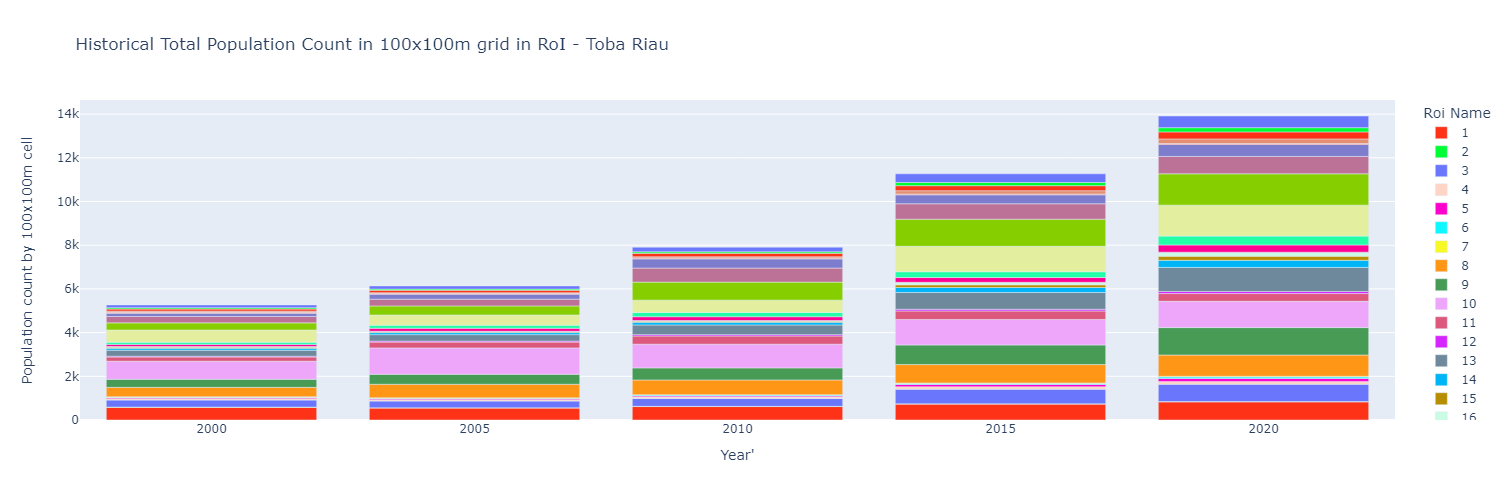

In [50]:
# Subset by RoI
historical_popCount_roi_df = historical_popCount_df[historical_popCount_df['Region'] == 'RoI']

# Bar Chart
fig_hist_pop00_20 = px.bar(historical_popCount_roi_df, 
                           x = historical_popCount_roi_df['Year'],
                           y = historical_popCount_roi_df['sum'],
                           color = roi_column_name,
                           color_discrete_sequence=px.colors.qualitative.Light24,
                           width=1400, height=500, 
                           labels = {'Year': "Year'", "sum": "Population count by 100x100m cell"},
                           title = "Historical Total Population Count in 100x100m grid in RoI - " + projectname)

fig_hist_pop00_20.update_layout(legend_title_text ='Roi Name')

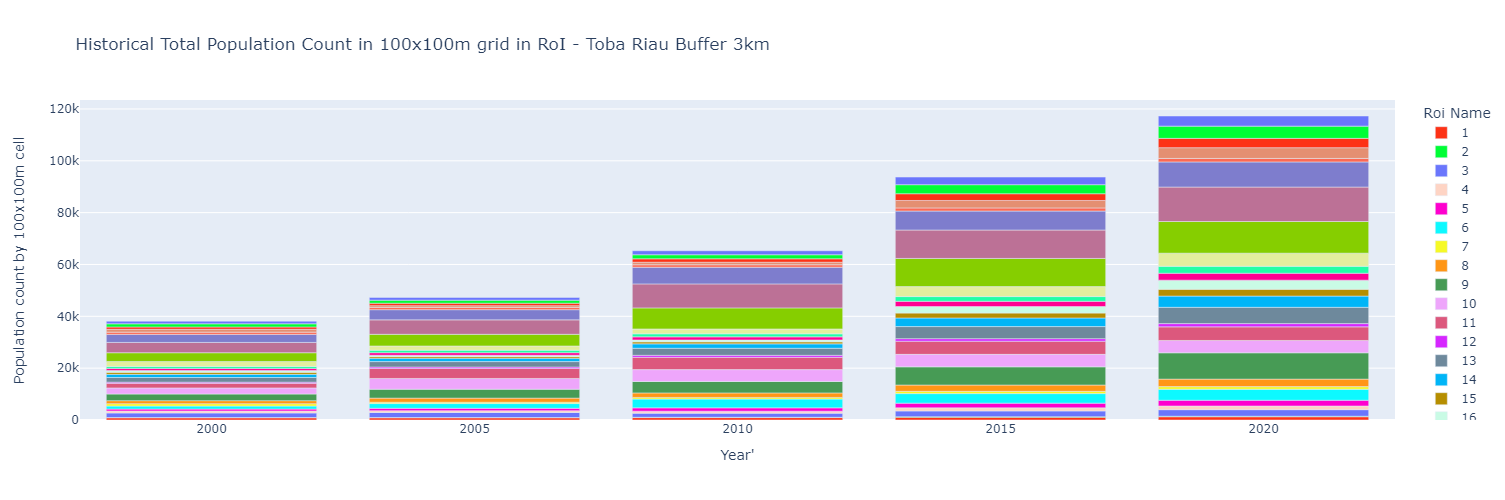

In [51]:
# Subset by by buffer 3km
historical_popCount_buf3km_df = historical_popCount_df[historical_popCount_df['Region'] == 'Buffer 3Km']

# Bar Chart
fig_hist_pop00_20_buf3km = px.bar(historical_popCount_buf3km_df,
                                  x = historical_popCount_buf3km_df['Year'],
                                  y = historical_popCount_buf3km_df['sum'],
                                  color = roi_column_name,
                                  color_discrete_sequence=px.colors.qualitative.Light24,
                                  width=1400, height=500, 
                                  labels = {'Year': "Year'", "sum": "Population count by 100x100m cell"},
                                  title = "Historical Total Population Count in 100x100m grid in RoI - " + projectname + " Buffer 3km")

fig_hist_pop00_20_buf3km.update_layout(legend_title_text ='Roi Name')

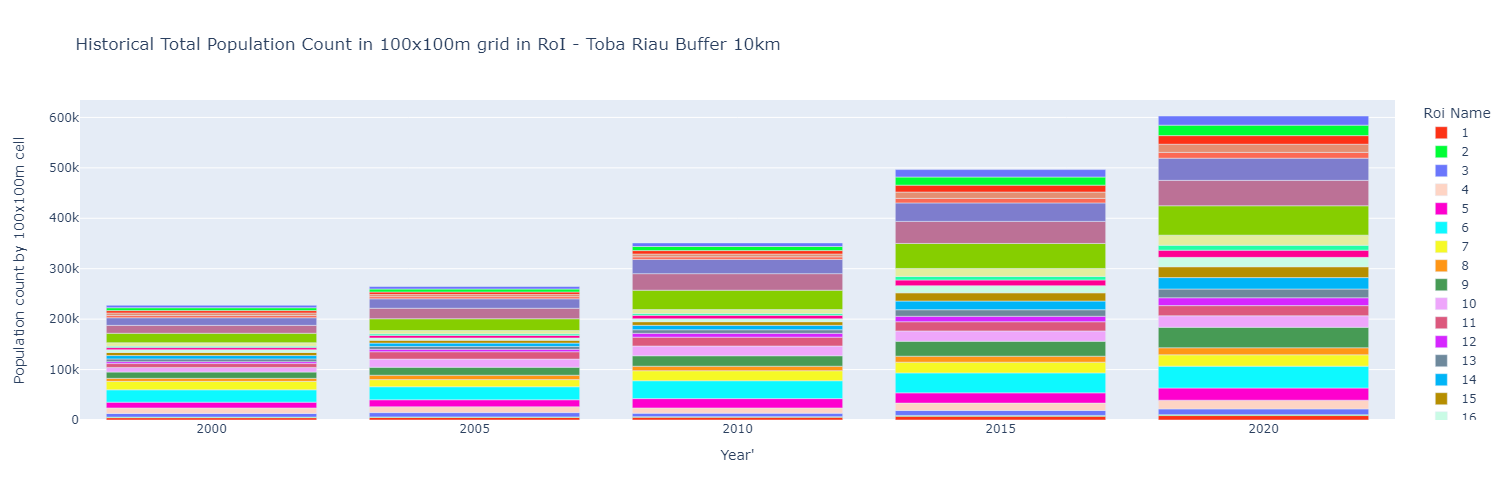

In [52]:
# Subset by by buffer 10km
historical_popCount_buf10km_df = historical_popCount_df[historical_popCount_df['Region'] == 'Buffer 10Km']

# Bar Chart
fig_hist_pop00_20_buf10km = px.bar(historical_popCount_buf10km_df,
                                  x = historical_popCount_buf10km_df['Year'],
                                  y = historical_popCount_buf10km_df['sum'],
                                  color = roi_column_name,
                                  color_discrete_sequence=px.colors.qualitative.Light24,
                                  width=1400, height=500, 
                                  labels = {'Year': "Year'", "sum": "Population count by 100x100m cell"},
                                  title = "Historical Total Population Count in 100x100m grid in RoI - " + projectname + " Buffer 10km")

fig_hist_pop00_20_buf10km.update_layout(legend_title_text ='Roi Name')

##### Jurisdictional

In [53]:
historical_popCount_jur_df = pd.DataFrame()
years_list = [2000,2005,2010,2015,2020]

for y in years_list:
    jur_PopCount = pd.read_csv(os.path.join(out_dir, projectname + '_WorldPop_PopCount_' + str(y) + '_jurisdictional.csv'))
    jur_PopCount['Year'] = y
    jur_PopCount['Year'] = jur_PopCount['Year'].astype('Int64')
    jur_PopCount['Region'] = 'Jurisdictiional'
    historical_popCount_jur_df = historical_popCount_jur_df.append(jur_PopCount)

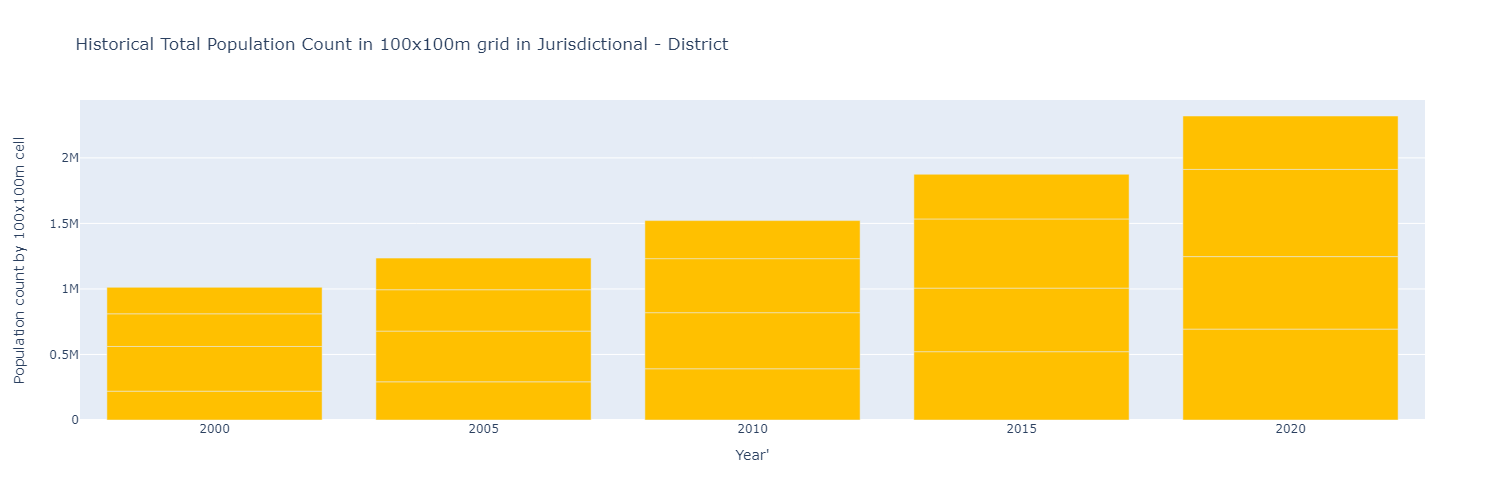

In [54]:
# Bar Chart Jurisdictional
fig_hist_pop00_20_jur = px.bar(historical_popCount_jur_df, 
                           x = historical_popCount_jur_df['Year'],
                           y = historical_popCount_jur_df['sum'],
                           color_discrete_sequence = ['#FFC000'],
                           width=1400, height=500, 
                           labels = {'Year': "Year'", "sum": "Population count by 100x100m cell"},
                           title = "Historical Total Population Count in 100x100m grid in Jurisdictional - " + jurisdictionalname)

fig_hist_pop00_20_jur.update_layout(legend_title_text ='Jurisdiction Name')

In [55]:
#  Export graphs
fig_hist_pop00_20.write_image(os.path.join(out_dir, projectname + '_RoI_TotalPopulation_2000_2020_Graph.png'))
fig_hist_pop00_20_buf3km.write_image(os.path.join(out_dir, projectname + '_Buffer3km_TotalPopulation_2000_2020_Graph.png'))
fig_hist_pop00_20_buf10km.write_image(os.path.join(out_dir, projectname + '_Buffer10km_TotalPopulation_2000_2020_Graph.png'))
fig_hist_pop00_20_jur.write_image(os.path.join(out_dir, projectname + '_Jurisdictional_TotalPopulation_2000_2020_Graph.png'))

# Export csv files
historical_popCount_df.to_csv(os.path.join(out_dir, projectname + '_TotalPopChange_2000_2020.csv'))
historical_popCount_jur_df.to_csv(os.path.join(out_dir, jurisdictionalname + '_TotalPopChange_2000_2020.csv'))